In [1]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv("Customer_sentiment.csv")
df.head(5)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4620 entries, 0 to 4619
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   rating    4620 non-null   int64 
 1   date      4620 non-null   object
 2   review    4620 non-null   object
 3   platform  4620 non-null   object
dtypes: int64(1), object(3)
memory usage: 144.5+ KB


In [2]:
#feature engineering


import re
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['review'].astype(str).apply(clean_text) 
# Label sentiment based on rating
def label_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'
df['sentiment'] = df['rating'].apply(label_sentiment)
#word count
df['review_word_count'] = df['review'].astype(str).apply(lambda x: len(x.split()))

#keywords 
# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['cleaned_text'])
feature_names = tfidf.get_feature_names_out()

# Function to get top N keywords for each review
def get_top_keywords(row_vector, feature_names, top_n=5):
    sorted_indices = np.argsort(row_vector.data)[::-1][:top_n]
    top_features = [feature_names[row_vector.indices[i]] for i in sorted_indices]
    return ", ".join(top_features)

# Apply to each row
df['top_keywords'] = [get_top_keywords(X[i], feature_names) for i in range(X.shape[0])]
df.head(5)

,rating,date,review,platform,cleaned_text,sentiment,review_word_count,top_keywords
0,2,30 December 2024,"I was using it for long time, but have to stop...",blinkit,using long time stop using recently got used i...,negative,68,"image, product image, image product, using, pr..."
1,1,4 November 2024,Loving the fast deliveries and mostly they are...,blinkit,loving fast deliveries mostly great quick deli...,negative,75,"star, im, im stuck, loving, given star"
2,1,31 October 2024,The customer support is very disappointing. I ...,blinkit,customer support disappointing recently bought...,negative,80,"electronic products, trying reach, ive trying,..."
3,5,29 August 2024,"I've been using Blinkit for a while now, and i...",blinkit,ive using blinkit become goto app grocery shop...,positive,84,"super quick, blinkit goto, goto app, offers wi..."
4,2,31 December 2024,Blinkit was my go to app and it was rare that ...,blinkit,blinkit go app rare disappointed mebut today d...,negative,81,"disappointed, order items, room, order, regards"


In [3]:


# Step 1: Create initial frequency dict
sentiment_keyword_freq = defaultdict(Counter)

for _, row in df.iterrows():
    sentiment = row['sentiment']
    keywords = row['top_keywords'].split(', ')
    sentiment_keyword_freq[sentiment].update(keywords)

# Step 2: Sort keywords uniquely — prioritizing a fixed sentiment order
priority_order = ['positive', 'negative', 'neutral']
top_n = 15
used_keywords = set()
structured_keyword_dict = {}

for sentiment in priority_order:
    top_keywords = sentiment_keyword_freq[sentiment].most_common()
    unique_keywords = []

    for keyword, freq in top_keywords:
        if keyword not in used_keywords:
            unique_keywords.append((keyword, freq))
            used_keywords.add(keyword)
        if len(unique_keywords) == top_n:
            break

    structured_keyword_dict[sentiment] = dict(unique_keywords)

# Display the final cleaned dictionary
import pprint
pprint.pprint(structured_keyword_dict)


{'negative': {'cancel': 44,
              'cash': 78,
              'free': 45,
              'item': 55,
              'items': 55,
              'jiomart': 51,
              'location': 64,
              'mins': 39,
              'money': 41,
              'order': 47,
              'payment': 39,
              'return': 45,
              'rs': 58,
              'wallet': 81,
              'zepto cash': 49},
 'neutral': {'add': 5,
             'address': 4,
             'app slow': 3,
             'app year': 3,
             'available': 3,
             'cash delivery': 4,
             'change': 4,
             'dairy': 3,
             'initial': 3,
             'order thing': 3,
             'sorting': 3,
             'star': 4,
             'super saver': 3,
             'time': 3,
             'vegetables': 5},
 'positive': {'amazing': 13,
              'awesome': 15,
              'best': 16,
              'blinkit': 16,
              'charges': 12,
              'fast': 12,
    

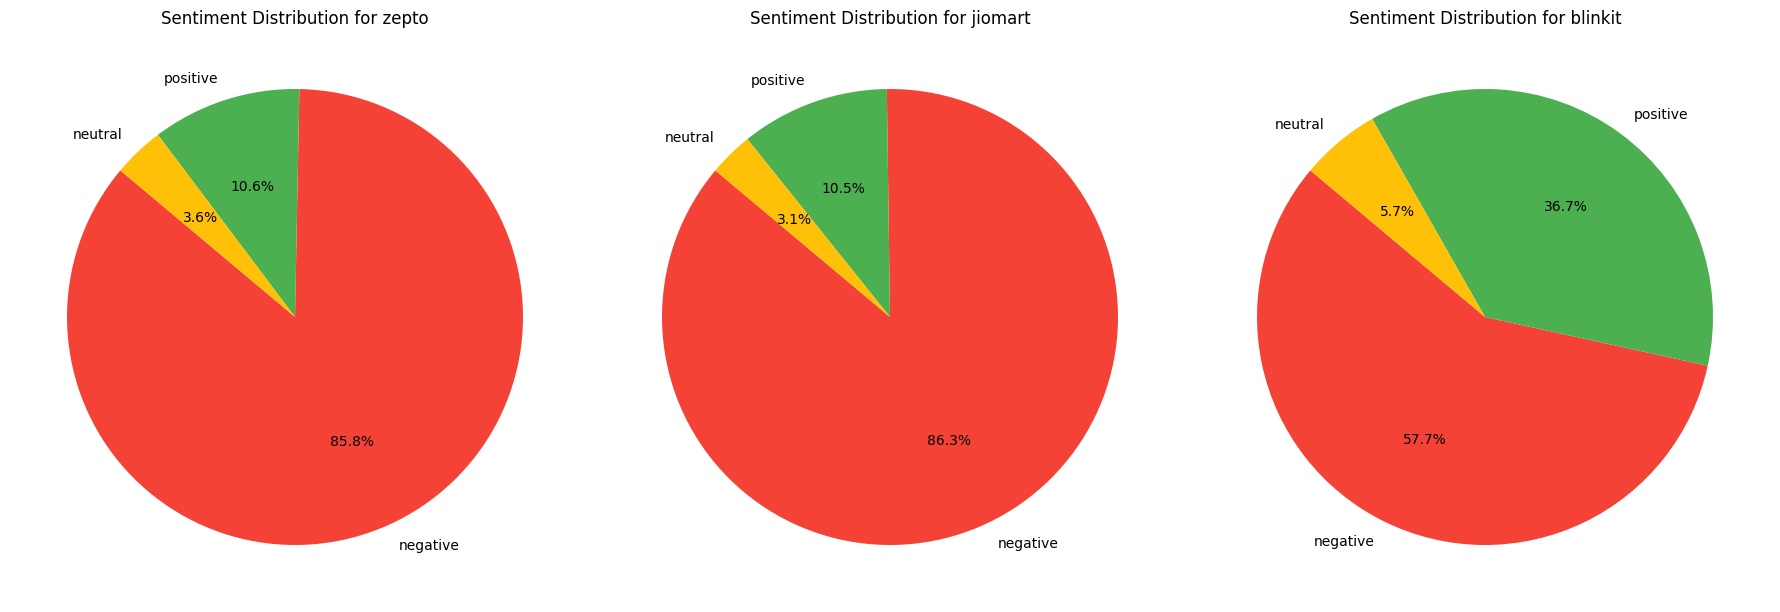

In [4]:
import matplotlib.pyplot as plt
top_platforms = df['platform'].value_counts().nlargest(3).index.tolist()

# Set up subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = {'positive': '#4CAF50', 'negative': '#F44336', 'neutral': '#FFC107'}

for i, platform in enumerate(top_platforms):
    platform_df = df[df['platform'] == platform]
    sentiment_counts = platform_df['sentiment'].value_counts()
    
    axes[i].pie(
        sentiment_counts,
        labels=sentiment_counts.index,
        autopct='%1.1f%%',
        colors=[colors.get(s, '#ccc') for s in sentiment_counts.index],
        startangle=140
    )
    axes[i].set_title(f"Sentiment Distribution for {platform}")

plt.tight_layout()
plt.show()

#Blinkit - Most positive reviews
#Jiomart - Most negative reviews

In [7]:


import warnings 

warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=4000, stop_words='english')
X = tfidf.fit_transform(df['cleaned_text'],df['review_word_count'])
y = df['sentiment_encoded']
# 1. TF-IDF on cleaned_text
tfidf_cleaned = TfidfVectorizer(max_features=3000)
X_cleaned = tfidf_cleaned.fit_transform(df['cleaned_text'].astype(str))

# 3. Numerical feature: review_word_count
X_wordcount = csr_matrix(df['review_word_count'].values.reshape(-1, 1))
# 5. Combine all features
X_combined = hstack([X_cleaned, X_wordcount])
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression with GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.1, 1, 10],
    'solver': ['saga'],
    'l1_ratio': [0.0, 0.5, 1.0]  # Only used with elasticnet
}
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression(max_iter=1000)
grid = GridSearchCV(log_reg, param_grid, scoring='f1_macro', cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
print("\nF1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'C': 10, 'l1_ratio': 0.0, 'penalty': 'l2', 'solver': 'saga'}

F1 Score (weighted): 0.8508278996144578

Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.99      0.93       717
     neutral       0.00      0.00      0.00        38
    positive       0.92      0.59      0.72       169

    accuracy                           0.88       924
   macro avg       0.60      0.53      0.55       924
weighted avg       0.84      0.88      0.85       924



In [14]:
# Define base models
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

# Define hyperparameter grid
param_grid = {
    'rf__n_estimators': [500,700],
    'rf__max_depth': [100,200],
    'xgb__n_estimators': [500,700],
    'xgb__max_depth': [5],
    'xgb__learning_rate': [0.1]
}

# Grid Search CV
grid = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Predictions
y_pred1 = best_model.predict(X_test)

# Evaluation
print("\nF1 Score (weighted):", f1_score(y_test, y_pred1, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred1, target_names=label_encoder.classes_))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'rf__max_depth': 100, 'rf__n_estimators': 500, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 700}

F1 Score (weighted): 0.8847001649128482

Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.98      0.94       711
     neutral       1.00      0.03      0.06        32
    positive       0.90      0.75      0.82       181

    accuracy                           0.90       924
   macro avg       0.93      0.59      0.61       924
weighted avg       0.90      0.90      0.88       924



In [13]:
tfidf = TfidfVectorizer(max_features=4000)
X_text = tfidf.fit_transform(df['cleaned_text'].astype(str))


X_word_count = csr_matrix(df['review_word_count'].values.reshape(-1, 1))
X = hstack([X_text, X_word_count])
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
grid = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=3, scoring='f1_macro', verbose=1)
grid.fit(X_train, y_train)
best_nb = grid.best_estimator_
y_pred2 = best_nb.predict(X_test)

print("Best Alpha:", grid.best_params_)
print("F1 Score (weighted):", f1_score(y_test, y_pred2, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred2))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Alpha: {'alpha': 0.1}
F1 Score (weighted): 0.8744839303232224
Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.98      0.93       711
     neutral       0.50      0.03      0.06        32
    positive       0.88      0.70      0.78       181

    accuracy                           0.89       924
   macro avg       0.76      0.57      0.59       924
weighted avg       0.88      0.89      0.87       924




Weighted F1 Score: 0.8847

Classification Report:

              precision    recall  f1-score   support

    negative       0.90      0.98      0.94       711
     neutral       1.00      0.03      0.06        32
    positive       0.90      0.75      0.82       181

    accuracy                           0.90       924
   macro avg       0.93      0.59      0.61       924
weighted avg       0.90      0.90      0.88       924



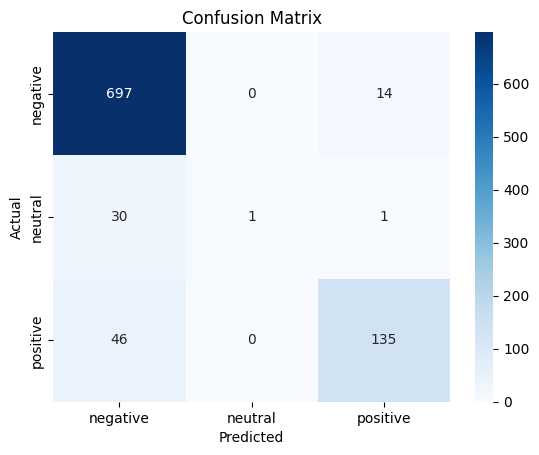


ANOVA Results:
             Feature     F-Value       P-Value
0  review_word_count  136.594518  2.325482e-58


In [19]:
# F1 Score (macro = balanced across classes)
f1 = f1_score(y_test, y_pred1, average='weighted')
print(f"\nWeighted F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred1))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred1, labels=best_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

from sklearn.feature_selection import f_classif

# If needed: encode sentiments as numeric for ANOVA
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['sentiment'])

# Ensure numeric feature input
X_anova = df[['review_word_count']]  # you can add more numeric features here

# Apply ANOVA F-test
f_values, p_values = f_classif(X_anova, y_encoded)

# Display results
anova_results = pd.DataFrame({
    'Feature': X_anova.columns,
    'F-Value': f_values,
    'P-Value': p_values
})

print("\nANOVA Results:")
print(anova_results)

In [ ]:
THEREFORE THE BEST PERFORMING MODEL IS WITH VOTING-CLASSIFIER ( XGBOOST + RANDOMFOREST)

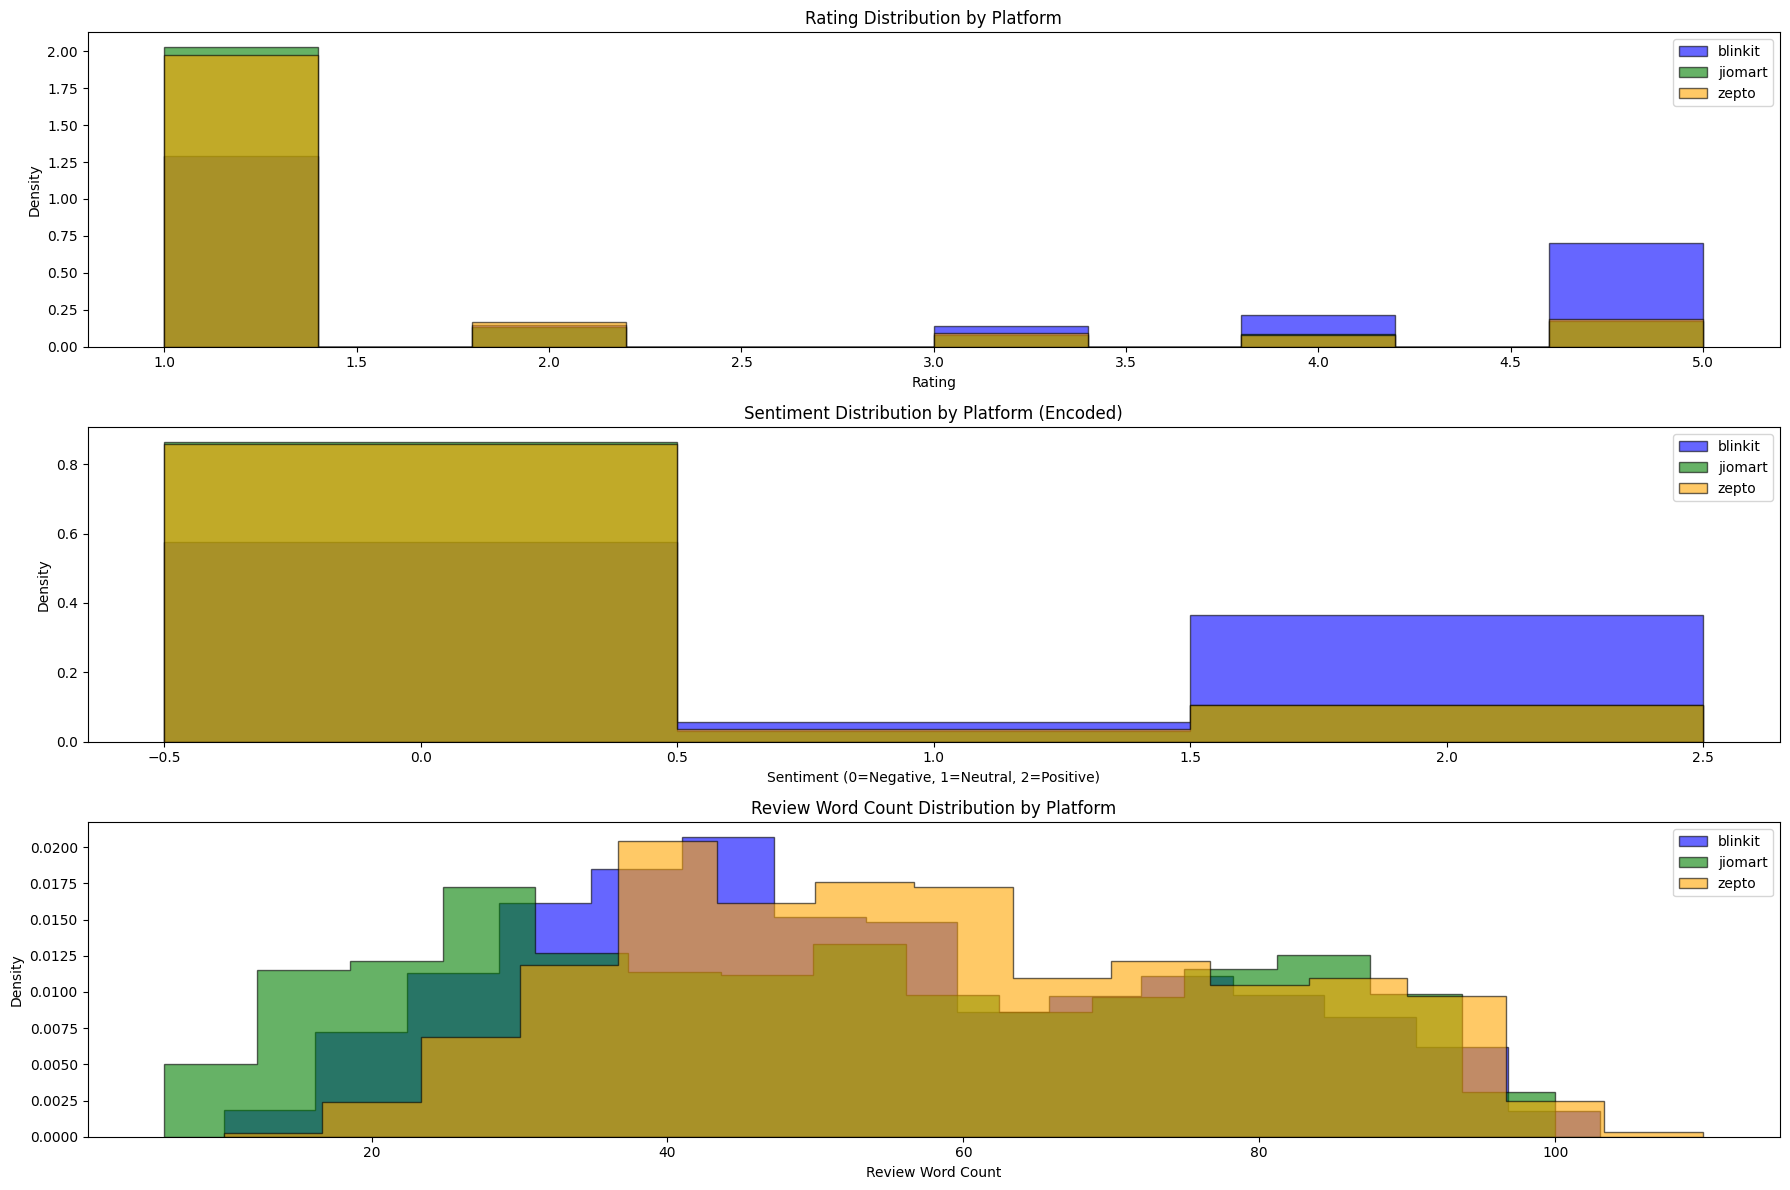

In [20]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Clean platform names
df['platform'] = df['platform'].str.lower().str.strip()

# Encode sentiment to numeric values
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'].astype(str))

# Set unique platforms
platforms = df['platform'].unique()
colors = ['blue', 'green', 'orange']  # customize if more platforms

# Create subplots
plt.figure(figsize=(18, 12))

# --- Plot 1: Rating Distribution ---
plt.subplot(3, 1, 1)
for platform, color in zip(platforms, colors):
    platform_data = df[df['platform'] == platform]['rating'].dropna()
    plt.hist(platform_data, bins=10, label=platform, density=True, 
             alpha=0.6, edgecolor='black', histtype='stepfilled', color=color)
plt.title("Rating Distribution by Platform")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.legend()

# --- Plot 2: Sentiment Distribution ---
plt.subplot(3, 1, 2)
for platform, color in zip(platforms, colors):
    sentiment_data = df[df['platform'] == platform]['sentiment_encoded'].dropna()
    plt.hist(sentiment_data, bins=[-0.5, 0.5, 1.5, 2.5], label=platform, 
             density=True, align='mid', rwidth=0.8, alpha=0.6, 
             edgecolor='black', histtype='stepfilled', color=color)
plt.title("Sentiment Distribution by Platform (Encoded)")
plt.xlabel("Sentiment (0=Negative, 1=Neutral, 2=Positive)")
plt.ylabel("Density")
plt.legend()

# --- Plot 3: Review Word Count Distribution ---
plt.subplot(3, 1, 3)
for platform, color in zip(platforms, colors):
    word_count_data = df[df['platform'] == platform]['review_word_count'].dropna()
    plt.hist(word_count_data, bins=15, label=platform, density=True, 
             alpha=0.6, edgecolor='black', histtype='stepfilled', color=color)
plt.title("Review Word Count Distribution by Platform")
plt.xlabel("Review Word Count")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()


From graph inferfence : 

1. zepto's reviews word count is in higher range (which has more negative reviews)
2. blinkit most reviews are short (which has more positive reviews)
3. jiomart's distribution is uniform therefore occur more in medium range